# IBM Optimizations using Cirq

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Infleqtion/client-superstaq/blob/main/docs/source/optimizations/ibm/ibmq_compile_css.ipynb) [![Launch Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Infleqtion/client-superstaq/HEAD?labpath=docs/source/optimizations/ibm/ibmq_compile_css.ipynb)

Below is a brief tutorial on Superstaq optimizations for IBM Quantum superconducting qubit devices. For more information on IBM Quantum, visit their website [here](https://www.ibm.com/quantum).

## Imports and API Token

This example tutorial notebook uses `cirq-superstaq`, our Superstaq client for Cirq; you can try it out by running `pip install cirq-superstaq[examples]`:

In [1]:
try:
    import cirq_superstaq as css
    import qiskit_superstaq as qss
except ImportError:
    print("Installing cirq-superstaq[examples]...")
    %pip install --quiet 'cirq-superstaq[examples]'
    print("Installed cirq-superstaq[examples].")
    print("You may need to restart the kernel to import newly installed packages.")
    import cirq_superstaq as css

import random

import cirq
import numpy as np
import qiskit
import qiskit_superstaq as qss

To interface Superstaq via Cirq, we must first instantiate a service with `cirq_superstaq.Service()`. We then supply a Superstaq API token by either providing the API token as an argument to `cirq_superstaq.Service()` or by setting it as an environment variable (see more details [here](https://superstaq.readthedocs.io/en/latest/get_started/basics/basics_css.html#Set-up-access-to-Superstaq%E2%80%99s-API))

In [2]:
# Provide your Superstaq API key using the "api_key" argument
service = css.Service()

## Single Circuit Compilation

Let us start by creating an example Cirq circuit that we will then compile and optimize for the 156-qubit IBM Quantum `Kingston` processor.

In [3]:
# Create a two-qubit cirq circuit
qubits = cirq.LineQubit.range(2)
rng = np.random.default_rng(random.getrandbits(128))
theta = rng.uniform(0, 4 * np.pi)
circuit = cirq.Circuit(
    cirq.CNOT(qubits[0], qubits[1]),
    cirq.Rz(rads=theta)(qubits[1]),
    cirq.CNOT(qubits[0], qubits[1]),
    css.barrier(*qubits),
    cirq.measure(qubits[0], qubits[1]),
)

# Visualize circuit
circuit

0: ───@────────────────@───│───M───
      │                │   │   │
1: ───X───Rz(0.766π)───X───│───M───

We will now compile the above circuit to IBM's `Kingston` processor and visualize the differences by drawing the compiled circuit. 

In [4]:
# Compile with qscout compile
compiler_output = service.ibmq_compile(circuit, target="ibmq_kingston_qpu")

# Call circuit from the compiler output to get the corresponding output circuit
output_circuit = compiler_output.circuit

# Visualize the compiled circuit
output_circuit

133: ───Rz(0.75π)─────────────────────────X^0.5───Rz(1.25π)───@───Rz(0.75π)───────────X^0.5───Rz(1.23π)───X^0.5───Rz(0.25π)───@───Rz(1.75π)───X^0.5────────────────────────────Rz(1.25π)───│───M────────────────
                                                              │                                                               │                                                            │   │
134: ───WaitGate(32000.000000000007 ps)───────────────────────@───WaitGate(64.0 ns)───────────────────────────────────────────@───Rz(π)───────WaitGate(32000.00000000003 ps)───────────────│───M('q(0),q(1)')───

The resulting output is now a circuit compiled to `Kingston`'s native operations. With Superstaq compilation, you can also observe the gates and gate times for the compiled circuit using Qiskit’s timeline drawer (see [Qiskit Timeline Visualizations Documentation](https://docs.quantum.ibm.com/api/qiskit/qiskit.visualization.timeline_drawer)). 

Additionally, to ensure that the drawer has all the information on the instruction durations, we must also provide the `qiskit.transpiler.Target` of the corresponding backend the timeline is being generated for. It can be retrieved from `qiskit_superstaq` like so:

In [5]:
backend_target = qss.SuperstaqProvider().get_backend("ibmq_kingston_qpu").target

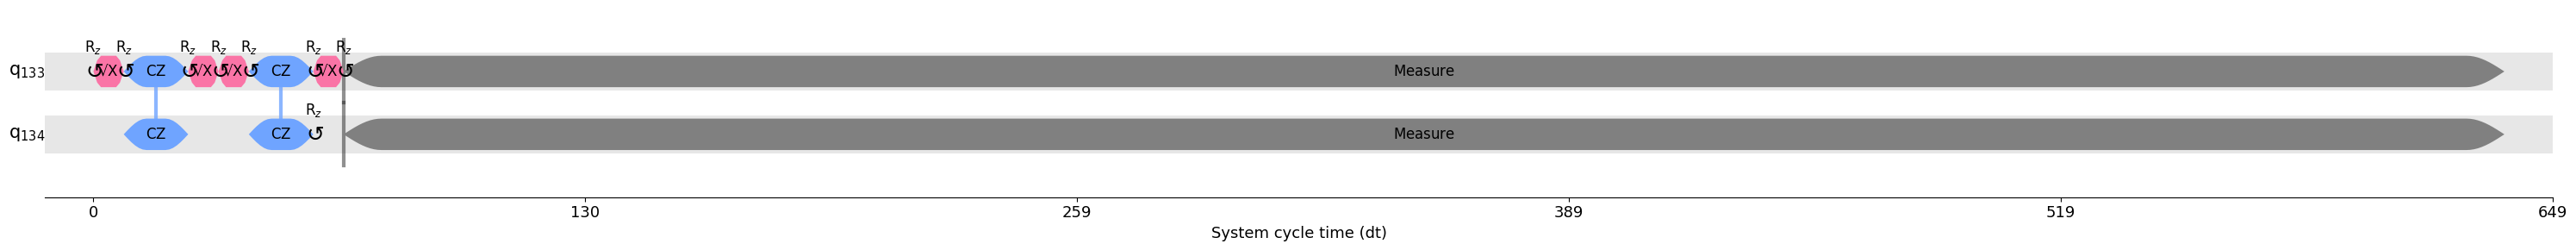

In [6]:
# The pulse gate circuit is obtained via the `pulse_gate_circuit` attribute
pulse_circuit = compiler_output.pulse_gate_circuit

# Estimate circuit duration for the timeline drawer
pulse_circuit.duration = pulse_circuit.estimate_duration(backend_target, unit="dt")

custom_style = {"formatter.general.fig_width": 30, "formatter.general.fig_unit_height": 1}
style = qiskit.visualization.timeline.IQXStandard(**custom_style)

qiskit.visualization.timeline_drawer(
    pulse_circuit, idle_wires=False, style=style, target=backend_target
)

## Multiple Circuits Compilation

All the functionalities we have seen so far can also be used on a multiple-circuit input as well. To illustrate this, let us create a different example two-qubit circuit: a Bell-state circuit.

In [7]:
# Create second circuit
bell_circuit = cirq.Circuit(
    cirq.H(qubits[0]), cirq.CNOT(qubits[0], qubits[1]), cirq.measure(qubits[0], qubits[1])
)

# Visualize second circuit
bell_circuit

0: ───H───@───M───
          │   │
1: ───────X───M───

By passing multiple circuits as a list to the `ibmq_compile` endpoint, we can compile all of them individually with a single call to the endpoint. This will return all the corresponding compiled circuits and pulse gate circuits back as a list, like so:  

In [8]:
# Create list of circuits
circuit_list = [circuit, bell_circuit]

# Compile list of circuits
compiler_output_list = service.ibmq_compile(circuit_list, "ibmq_kingston_qpu")

# The list of compiled output circuits is stored in the `circuits` attribute instead of `circuit`. Likewise for
# pulse gate circuits.
output_circuits = compiler_output_list.circuits
pulse_gate_circuits = compiler_output_list.pulse_gate_circuits

In [9]:
# Visualize the first compiled circuit
print("Compiled circuit 1 \n")
output_circuits[0]

Compiled circuit 1 



133: ───Rz(0.75π)─────────────────────────X^0.5───Rz(1.25π)───@───Rz(0.75π)───────────X^0.5───Rz(1.23π)───X^0.5───Rz(0.25π)───@───Rz(1.75π)───X^0.5────────────────────────────Rz(1.25π)───│───M────────────────
                                                              │                                                               │                                                            │   │
134: ───WaitGate(32000.000000000007 ps)───────────────────────@───WaitGate(64.0 ns)───────────────────────────────────────────@───Rz(π)───────WaitGate(32000.00000000003 ps)───────────────│───M('q(0),q(1)')───

In [10]:
# Estimate circuit durations for the timeline drawer
for pg_circ in pulse_gate_circuits:
    pg_circ.duration = pg_circ.estimate_duration(backend_target, unit="dt")

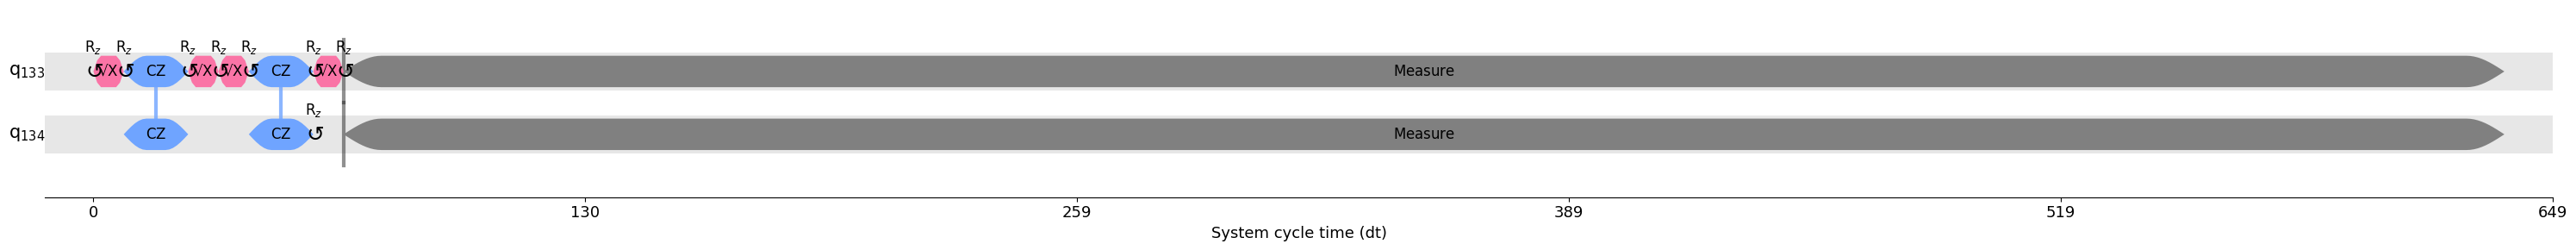

In [11]:
# Visualize the pulse gate circuit for the first compiled circuit
qiskit.visualization.timeline_drawer(
    pulse_gate_circuits[0], idle_wires=False, style=style, target=backend_target
)

In [12]:
# Visualize the second compiled circuit
print("Compiled circuit 2 \n")
output_circuits[1]

Compiled circuit 2 



133: ───Rz(0.5π)───X^0.5───Rz(π)───@───X^0.5───────────────│───M────────────────
                                   │                       │   │
134: ───Rz(0.5π)───X^0.5───────────@───WaitGate(32.0 ns)───│───M('q(0),q(1)')───

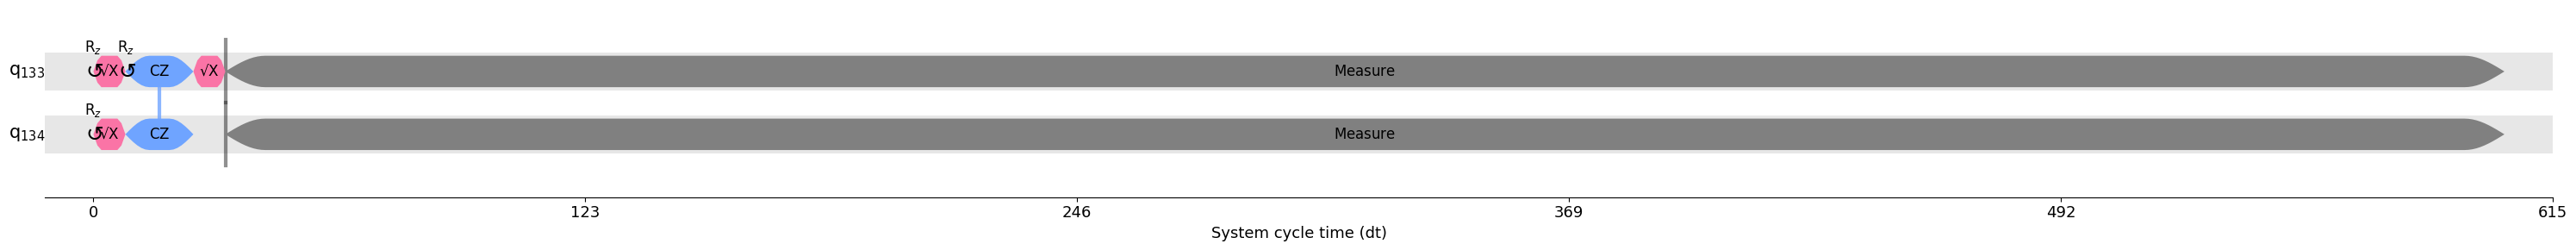

In [13]:
# Visualize the pulse gate circuit for the second compiled circuit
qiskit.visualization.timeline_drawer(
    pulse_gate_circuits[1], idle_wires=False, style=style, target=backend_target
)

## Using the Superstaq Simulator

Lastly, we will show (a) how to submit a circuit to a backend and (b) how to simulate circuit execution. Simulation is available to free trial users, and can be done by passing the `"dry-run"` method parameter when calling `create_job()` on the Superstaq service.

In [14]:
# Create job that submits to IBM Quantum backend
job = service.create_job(
    bell_circuit,
    repetitions=1000,
    target="ibmq_kingston_qpu",
    method="dry-run",  # Specify "dry-run" as the method to run Superstaq simulation
)

# Get the counts from the measurement
print(job.counts(0))

{'00': 501, '11': 499}
